<img src="https://www.th-ab.de/typo3conf/ext/th_ab/Resources/Public/assets/logo-th-ab.svg" alt="TH-AB Logo" width="200"/>

Prof. Dr. Möckel, Prof. Dr. Radke, K. Kuhnert

Maschinelles Lernen Schwerpunkt Data Science<br>
SoSe 2024

# Vorlesung 4: Clustering 

Hilfreiche Übersicht verschiedener Cluster-Algorithmen und ihrer Implementierung in scikit-learn:

 https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In scikit-learn finden sich neben den zentralen Cluster-Algorithmen auch Konstruktoren für synthetische Beispieldatensätze zur Illustration. Sie erzeugen Datenpunkte nach bestimmten Mustern (blons, moons, circles)

Dieses Skript illustriert ein mögliches Vorgehen im Falle des unsupervised learnings am Beispiel des  Clusterings von nicht gelabelten Daten

## Schritt 1: Daten laden und visualisieren

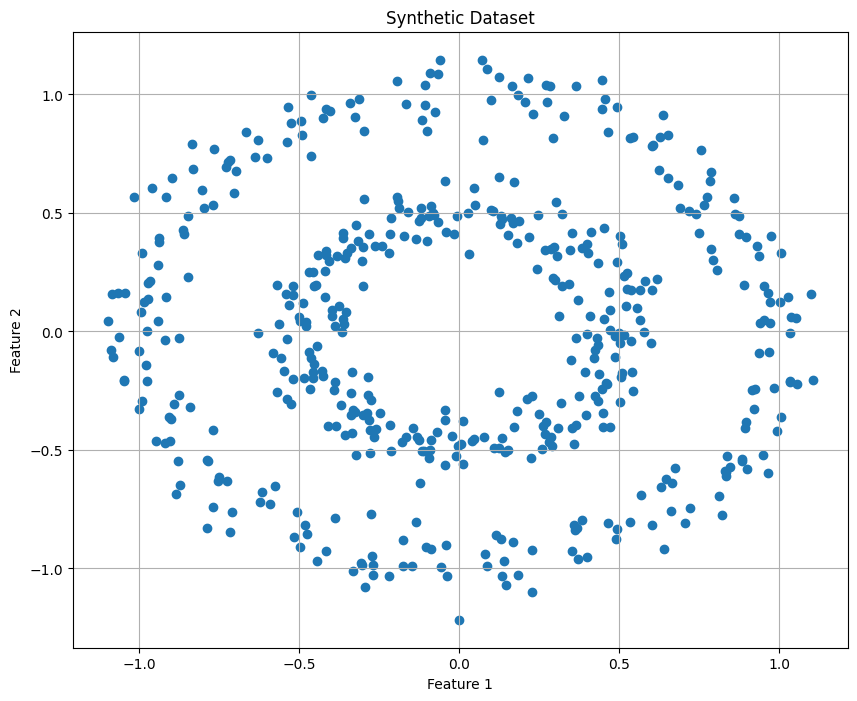

In [1]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# create synthetic dataset
X, _ = make_circles(n_samples=500, factor=0.5, noise=0.07, random_state=30)
X

# visualize dataset
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.grid(True)
plt.title("Synthetic Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## Schritt 2: Explorative Datenanalyse

Ziel ist es, die Daten mit Methoden der deskriptiven Statistik sowie anschaulich durch Visualisierung grob zu verstehen. 

### Semantics ##############
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       500 non-null    float64
 1   1       500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB

### NaN value summary ##############
0    0
1    0
dtype: int64

### Statistics ##############
                0           1
count  500.000000  500.000000
mean    -0.000754   -0.000140
std      0.563103    0.559876
min     -1.097337   -1.216470
25%     -0.421774   -0.433530
50%     -0.028983   -0.000257
75%      0.448060    0.414324
max      1.105455    1.146720

### Preview ##############
          0         1
0  0.975834  0.402780
1  0.924758 -0.242113
2 -0.897363  0.646877
3  0.383932  0.350619
4  0.874086  0.409495



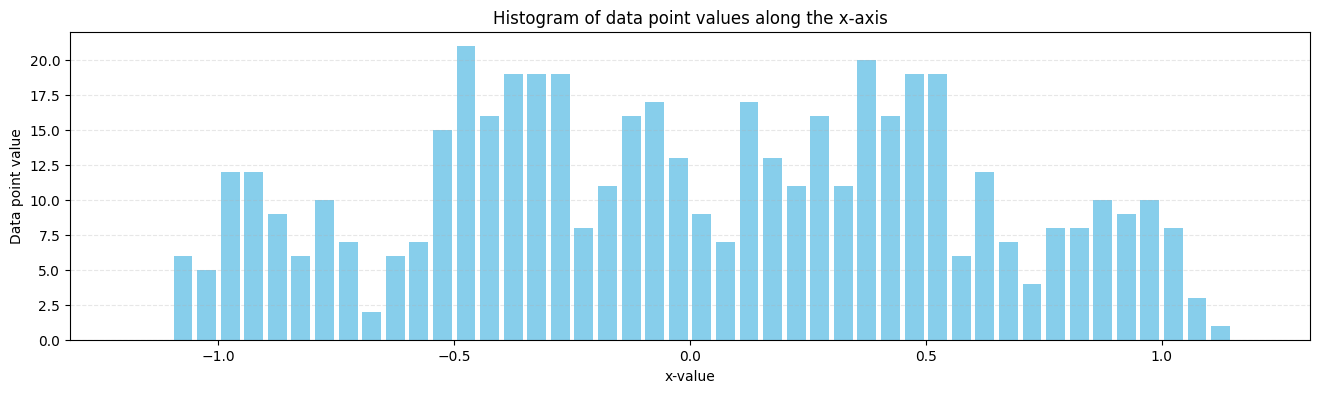

In [2]:
import numpy as np
import pandas as pd

# convert to dataframe
df_analyze = pd.DataFrame(X)

# show semantics
print("### Semantics ##############")
df_analyze.info()

# show potential null values
print(f"\n### NaN value summary ##############")
print(f"{df_analyze.isnull().sum()}\n")

# show statistics
print("### Statistics ##############")
print(f"{df_analyze.describe()}\n")

# preview dataset
print("### Preview ##############")
print(f"{df_analyze.head()}\n")

# plot histogram of labels
plt.figure(figsize=(16, 4))
hist, bins, _ = plt.hist(df_analyze.iloc[:, 0], bins=np.arange(-1.2, 1.21, 0.05), rwidth=0.8, color='skyblue')

plt.title('Histogram of data point values along the x-axis')
plt.xlabel('x-value')
plt.ylabel('Data point value')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

#### Technischer Einschub: Hilfefunktion für Plots

In [3]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)  # 2 std devs
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # The 'nsig' parameter scales the width and height by the number of standard deviations
    for nsig in range(1, 3):
        ellipse = Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs)
        ax.add_patch(ellipse)

def plot_covariance_ellipses(X, labels, centers, ax=None):
    """Plot ellipses for each cluster in X given by labels at centers"""
    ax = ax or plt.gca()
    labels = labels.astype(int)
    for i, center in enumerate(centers):
        data = X[labels == i]
        cov = np.cov(data, rowvar=False)
        draw_ellipse(center, cov, ax=ax, edgecolor='black', alpha=0.1, facecolor='yellow')

## 3. Schritt: Auswahl eines geeigneten Cluster-Algorithmus

### (1) K-Means

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans

* Simpler und effizienter Algorithmus
* Es muss die Anzahl der Cluster (Zentroide) vorgegeben werden
* Konvergiert, aber möglicherweise nur zu lokalen Minima
* Skaliert nichtlinear mit dem Datenvolumen

Verschiedene Implementierungen
* Für n_samples < 10k: KMeans
* Für n_samples > 10k: MiniBatchKMeans

**Achtung:** Die Qualität der erzeugten Cluster hängt stark von der Struktur der Daten ab. Wenn homogene Daten geclustert werden können zufällige Cluster entstehen, die (und insbesondere deren Grenzen) keine sinnvolle Bedeutung haben. 

**Vorsicht:** Sinnvolle Rückschlüsse können aus solchen Clustern nicht gewonnen werden! 

**Eine kritische Beurteilung der Ergebnisse eines Clusterings ist IMMER erforderlich!**

c:\Users\thiel\miniconda3\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Clusters: 4 <-> 4


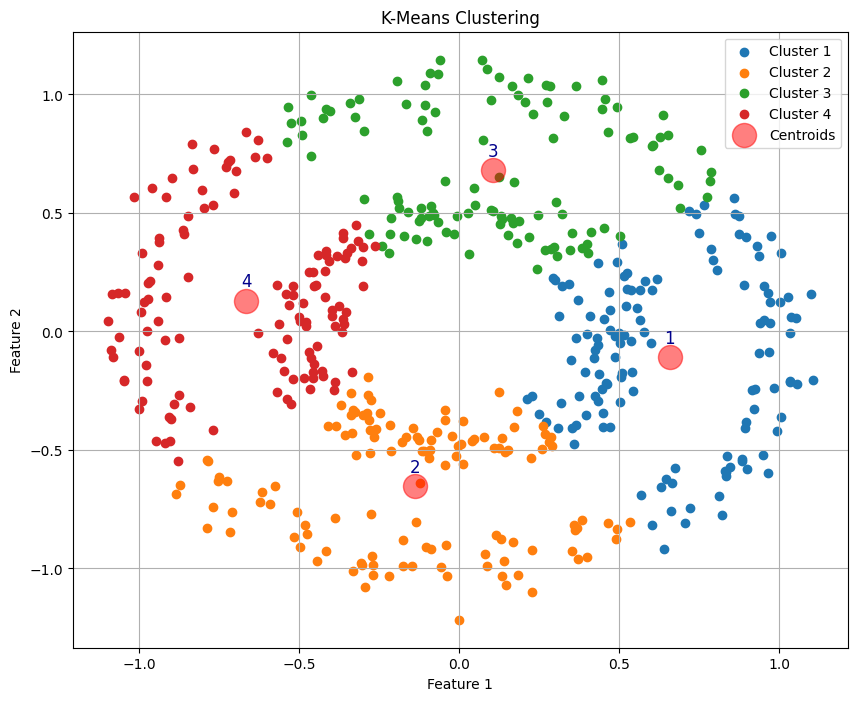

Verbleibender Wert der Summe aller quadratischen Abstände zu den Zentroiden (inertia): 86.72509241831203


In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

## setup hyperparameters
CLUSTERS = 4
# fixed seed is for reproducible cluster results
SEED = 42

## choose model
# apply k-means for n clusters
kmeans = KMeans(n_clusters=CLUSTERS, random_state=SEED)

## fitting (training) model
kmeans.fit(X)

## prediction (on the same data)
# apply K-Means model
y_kmeans = kmeans.predict(X)

# visualize cluster
labels = kmeans.labels_
plt.figure(figsize=(10, 8))

#
print(f"Clusters: {CLUSTERS} <-> {kmeans.n_clusters}")

# plot data points
for i in range(kmeans.n_clusters):
    plt.scatter(X[labels == i][:, 0], X[labels == i][:, 1], label='Cluster {}'.format(i+1))

# plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=300, alpha=0.5, label='Centroids')

# show number of cluster beneath centroids
for i, (cx, cy) in enumerate(centroids):
    plt.annotate(i+1, (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='darkblue')

# show grid
plt.grid(True)
# show legend
plt.legend()
# set title and labels
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

print(f"Verbleibender Wert der Summe aller quadratischen Abstände zu den Zentroiden (inertia): {kmeans.inertia_}")

#### Wahl der Anzahl von Clustern mittels "Elbow Curve"

Eine sinnvolle Auswahl an Clustern kann mit Hilfe der Inertia-Restwerte ermittelt werden. Die Kurve erinnert an einen Ellenbogen, da diese zu einem Grenzwert konvergiert.

c:\Users\thiel\miniconda3\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\thiel\miniconda3\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\thiel\miniconda3\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\thiel\miniconda3\envs\data_science\lib\site-packages\sklearn\cluster\_

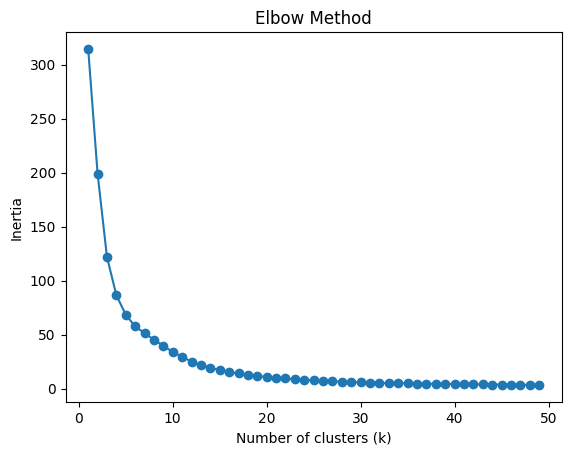

In [5]:
MAX_CLUSTERS = 50

# calculate inertia for different k values
inertia_values = []
for k in range(1, MAX_CLUSTERS):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# plot the elbow curve
plt.plot(range(1, MAX_CLUSTERS), inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

## (2) Mean Shift

https://scikit-learn.org/stable/modules/clustering.html#mean-shift

* Dichtebasiertes Verfahren
* Benötigt keine Vorgabe der Anzahl der Cluster
* Limitierte Skalierbarkeit - erfordert mehrfache Suchen während der Laufzeit um nächste Nachbarn zu bestimmen.

Number of estimated clusters: 4


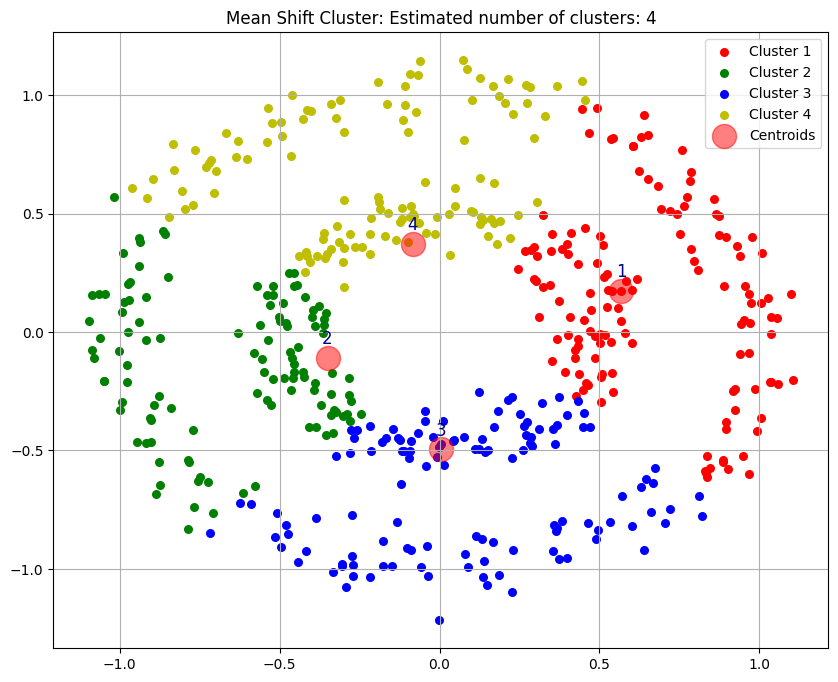

In [6]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# estimate bandwidth of kernel function
bandwidth = estimate_bandwidth(X, quantile=0.15, n_samples=500)

## choose model
# perform clustering with MeanShift
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

## fitting (training) model
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# number of clusters in labels, ignoring noise if present
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters:", n_clusters_)

# visualize dataset
plt.figure(figsize=(10, 8))

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i in range(n_clusters_):
    plt.scatter(X[labels == i][:, 0], X[labels == i][:, 1], color=colors[i % len(colors)], s=30, label='Cluster {}'.format(i+1))

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=300, alpha=0.5, label='Centroids')

# show number of cluster beneath centroids
for i, (cx, cy) in enumerate(cluster_centers):
    plt.annotate(i+1, (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='darkblue')

plt.grid(True)
plt.title('Mean Shift Cluster: Estimated number of clusters: %d' % n_clusters_)
plt.legend()
plt.show()



### Metriken zur Beurteilung von Clustering-Verfahren

Silhouette score
* possible metrics for assessing clustering quality
* calculated from the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. 
* The Silhouette Coefficient for a sample is (b - a) / max(a, b).
* -1: worst possible value, +1 best possible value
* biased towards convex clusters (DBSCAN, etc.), critical discussion needed for other clustering methods

In [7]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X, ms.labels_)
print(f"Silhouette AVG: {silhouette_avg}")

Silhouette AVG: 0.3681635569720459


## (3) Gaussian Mixture

https://scikit-learn.org/stable/modules/mixture.html#gaussian-mixture

* Dichtebezogenes Clusterverfahren 
* Verschiedene Verfahren: Spherical, Diagonal, Tied, Full Covariance

c:\Users\thiel\miniconda3\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


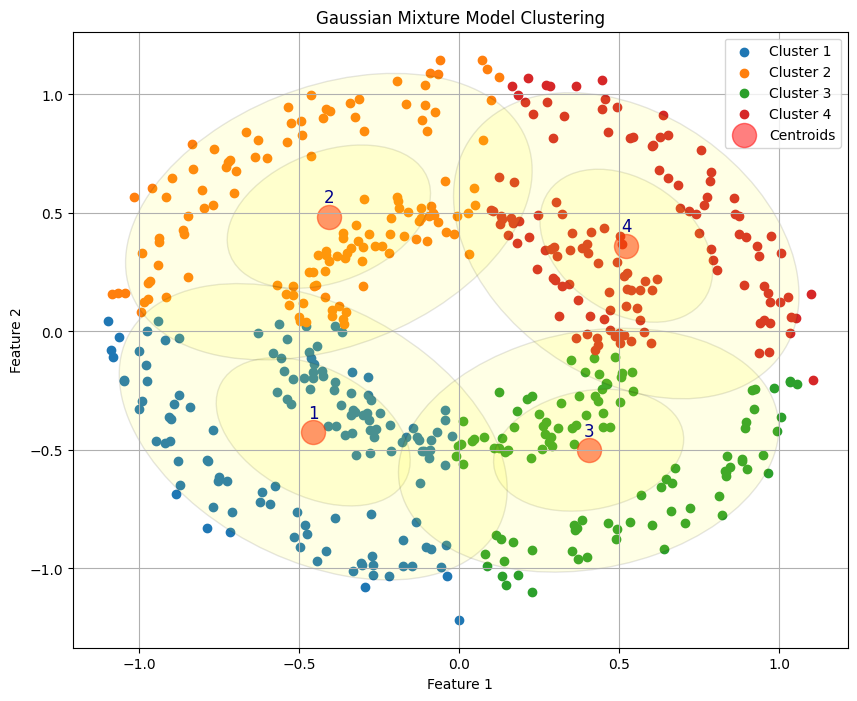

Silhouette AVG: 0.36150076548243504


In [8]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pandas as pd

## setup hyperparameters
COMPONENTS = 4
TYPE = "full" # spherical, diag, tied, full

## choose model
# apply Gaussian mixture model
gmm = GaussianMixture(n_components=COMPONENTS, covariance_type=TYPE)

## fitting (training) model
gmm.fit(X)

## prediction (on the same data)
labels = gmm.predict(X)
probs = gmm.predict_proba(X)

# visualize cluster
plt.figure(figsize=(10, 8))

for i in range(gmm.n_components):
    plt.scatter(X[labels == i][:, 0], X[labels == i][:, 1], label='Cluster {}'.format(i+1))

# plot the means of the clusters
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', s=300, alpha=0.5, label='Centroids')

# show covariance ellipses
plot_covariance_ellipses(X, labels, gmm.means_)
# plot_radius_circles(X, y_kmeans, gmm.means_)

# show number of cluster beneath centroids
for i, (cx, cy) in enumerate(gmm.means_):
    plt.annotate(i+1, (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='darkblue')

plt.grid(True)
plt.legend()
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# determine clustering quality by using the silhouette score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X, gmm.predict(X))
print(f"Silhouette AVG: {silhouette_avg}")


## (4) DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

https://scikit-learn.org/stable/modules/clustering.html#dbscan

* Separiert Samples durch Bereiche mit hoher Dichte (distances between nearest points).
* Cluster können beliebige Formen aufweisen.
* Noise wird mit dem Wert -1 gelabelt

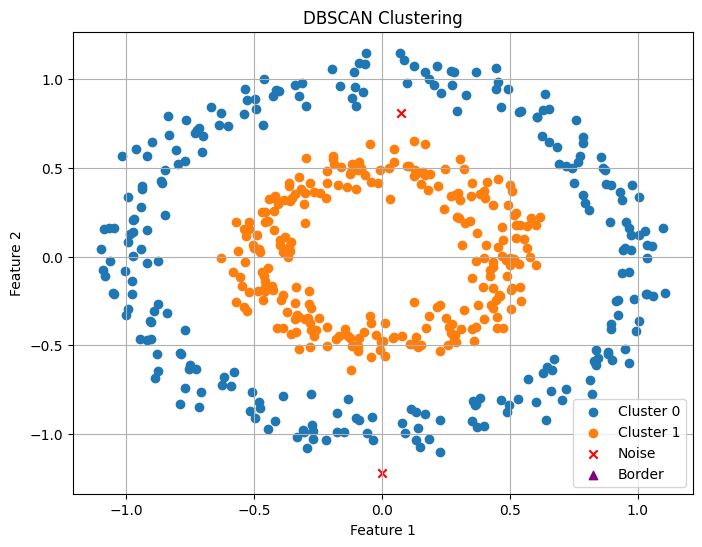

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import pandas as pd

## setup hyperparameters
DISTANCE_TRESHOLD = 0.15
NOISE_TOLERANCE = 5

## choose model
# apply DBSCAN model
dbscan = DBSCAN(eps=DISTANCE_TRESHOLD, min_samples=NOISE_TOLERANCE)

## fitting (training) model + prediction (on the same data)
y_dbscan = dbscan.fit_predict(X)

# get unique cluster labels (excluding noise points)
unique_labels = np.unique(dbscan.labels_[dbscan.labels_ != -1])

# compute pairwise distances between points
distances = euclidean_distances(X)

# find border points
border_points_mask = np.zeros(len(X), dtype=bool)
for i in range(len(X)):
    if dbscan.labels_[i] != -1:  # ignore noise points
        neighbor_labels = set(dbscan.labels_[distances[i] < dbscan.eps])
        if len(neighbor_labels) > 1:
            border_points_mask[i] = True

# visualize cluster

# plot cluster points
plt.figure(figsize=(8, 6))
for label in unique_labels:
    cluster = X[dbscan.labels_ == label]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {label}')

# plot noise points
noise_points = X[dbscan.labels_ == -1]
plt.scatter(noise_points[:, 0], noise_points[:, 1], c='red', marker='x', label='Noise')

# plot border points
border_points = X[border_points_mask]
plt.scatter(border_points[:, 0], border_points[:, 1], c='purple', marker='^', label='Border')

# show grid
plt.grid(True)
plt.legend()
plt.title("DBSCAN Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


# Awendungsbeispiel aus der wissenschaftlichen Datenanalyse

Use case: Im Rahmen der Überwachung des reflektierten Lichts in einem Verfahren der Lasermaterialbearbeitung sollen Sensordaten, die mit der Temperatur im Laserfokus korrelieren, auf Anomalien untersucht werden. 

### (1) Explorative Datenanalyse:

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# load normalized sample dataset
df = pd.read_csv('./CT_samples_norm_cleaned_slices.csv')

print(df.shape)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: './CT_samples_norm_cleaned_slices.csv'

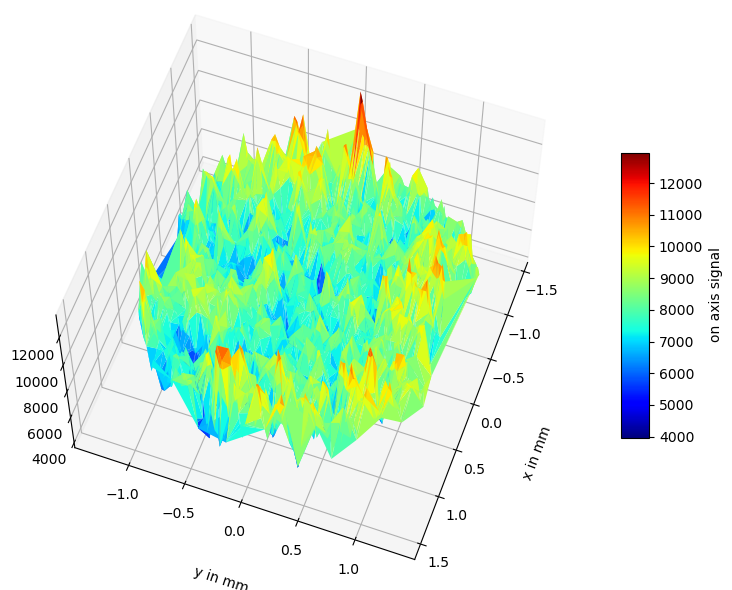

In [ ]:
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

# select a specific slice of the dataset
df_slice  = df.loc[(df['Job no.']==6) & (df['Slice']==50.5) & (df['on Axis']<15000.0)]

# visualize slice
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
name = 'on Axis'

# create a 3d surface by using samples as x,y,z coordinates
surf = ax.plot_trisurf(df_slice['PosX'], df_slice['PosY'], df_slice[name], cmap=cm.jet, linewidth=0)

# create color bar
cbar = fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.05)
cbar.set_label('on axis signal')

# set axis labels
ax.set_xlabel('x in mm', labelpad=22)
ax.set_ylabel('y in mm', labelpad=18)
ax.set_zlabel('on axis signal', labelpad=24)

fig.tight_layout()
ax.view_init(60, 20)
plt.show()

Oben: Temperaturverteilung in einer Schnittebene (Bauebene) des Werkstücks. Es fallen zwei Temperaturanomalien (rot) mit deutlich erhöhten Werten im on-axis Lasersignal auf. 

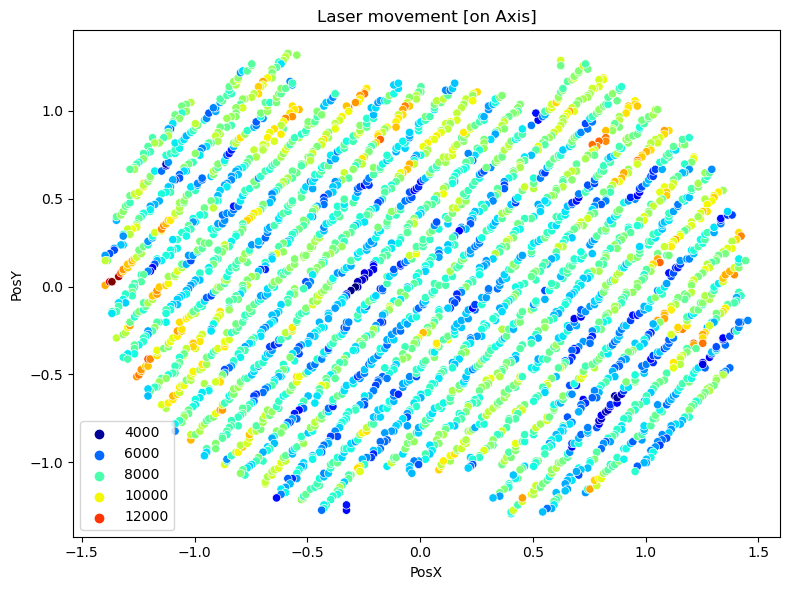

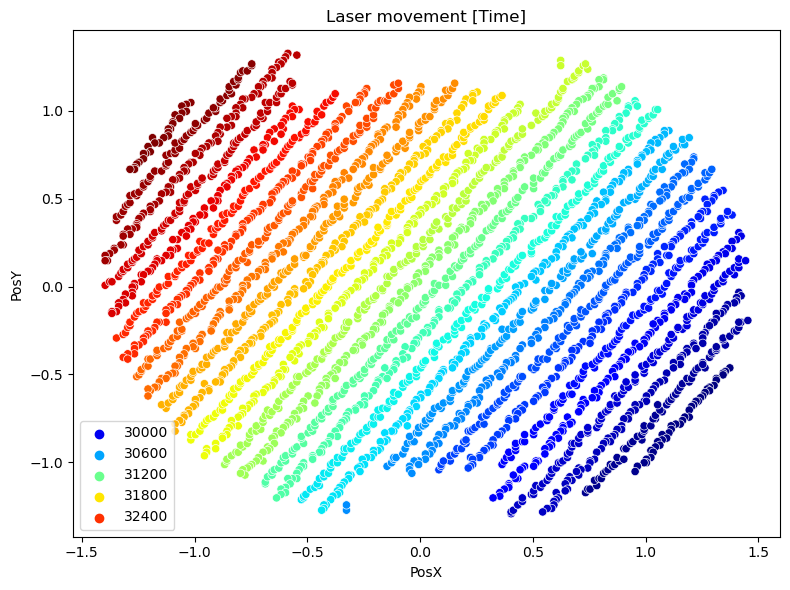

In [ ]:
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# select a specific slice of the dataset
df_cleaned  = df.loc[(df['Job no.']==6) & (df['Slice']==50.5) & (df['on Axis']<15000.0)]

# visualize moving pattern by [on Axis] value
plt.figure(figsize=(8, 6))
plt.title("Laser movement [on Axis]")
sns.scatterplot(x='PosX', y='PosY', hue='on Axis', data=df_cleaned, palette=cm.jet)
plt.legend()
plt.tight_layout()
plt.show()

# visualize moving pattern by [time] value
plt.figure(figsize=(8, 6))
plt.title("Laser movement [Time]")
sns.scatterplot(x='PosX', y='PosY', hue='Time', data=df_cleaned, palette=cm.jet)
plt.legend()
plt.tight_layout()
plt.show()

Darstellungen der Lasertrajektorie. Graphik 1: Signal der Photodiode; Graphik 2: Zeitkoordinate. Aus dem Anstieg der Zeitkoordinate lässt sich die Durchgangsrichtung des Laserstrahles erkennen (von kleinen zu großen Zeitwerten)

### (2) Analyse ausgewählter Anomalien mittels Clustering der on-axis Sensordaten mit DBSCAN

Die Zeitreihe wird in kleine Abschnitte mit 41 Datenpunkten unterteilt. Jeder Zeitreihe enthält am 21. Datenpunkt eine Temperaturanomalie (besonders hoher Wert). Das Clustering soll nun eingesetzt werden, um bestimmte charakteristische Teperaturverläufe (Kurvenverläufe) in der Umgebung der Anomalie zu finden. Es werden also ganze Kurven nach Art des Kurvenverlaufs mit DBSCAN geclustert.

In [ ]:
# load normalized sample dataset
df_job = pd.read_csv('./CT_samples_example.csv')

## setup hyperparameters
EPS = 0.55
MIN_SAMPLES= 2

## choose model
# apply DBSCAN
dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)

## fitting (training) model
y_dbscan = dbscan.fit(df_job)

# get fitted labels
labels = y_dbscan.labels_

print(len(labels))
print(len(labels[labels==-1]))
print(len(labels[labels==-1])/len(labels))
labels

197
125
0.6345177664974619


array([-1,  0,  1, -1, -1, -1, -1, -1,  2, -1,  3,  4, -1, -1,  5, -1, -1,
       -1, -1,  6, -1,  7, -1, -1, -1,  4,  6,  6, -1, -1, -1, -1,  7,  0,
       -1, -1, -1, -1,  6,  4,  0, -1, -1, -1, -1,  6,  0,  6, -1, -1, -1,
       -1, -1,  3,  7,  6, -1, -1,  8,  9, -1, -1, -1, -1, -1, -1,  3, -1,
       -1,  2, -1,  3,  8,  8, -1,  6, -1, -1,  6, -1, -1, -1, -1, -1,  7,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  7, -1, -1,  4, -1, -1, 10, 11,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  6, -1, -1, -1, -1,
       -1, -1, 12, -1, -1, -1, -1,  5, -1, -1,  1,  4,  4,  3, -1, 13,  6,
        6, 14,  1, -1, -1,  0,  4, 10,  0, -1,  1,  4, -1, 13,  7,  0, 14,
        6, 11, -1, 12, -1, -1, -1,  9, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1,  4, -1,  0, -1, -1, 13, -1,  4, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1,  4, -1, -1, -1,  3,  0,  7], dtype=int64)

Es wurden offensichtlich 15 Cluster gebildet (Nr 0-14). -1 beschreibt singuläre Kurven, die keinem Cluster angehören (Noise). 

Deutung: 

* Die allermeisten Kurvenverläufe sind untypisch und haben vermutlich keinen leicht zu deutenden Verlauf. 
* Die bestimmten Klassen bündeln bestimmte Situationen. Sie können wissenschaftlich weiter untersucht werden

#### Graphische Darstellung aller Ergebniscluster und der in ihnen vertretenden Kurven: 

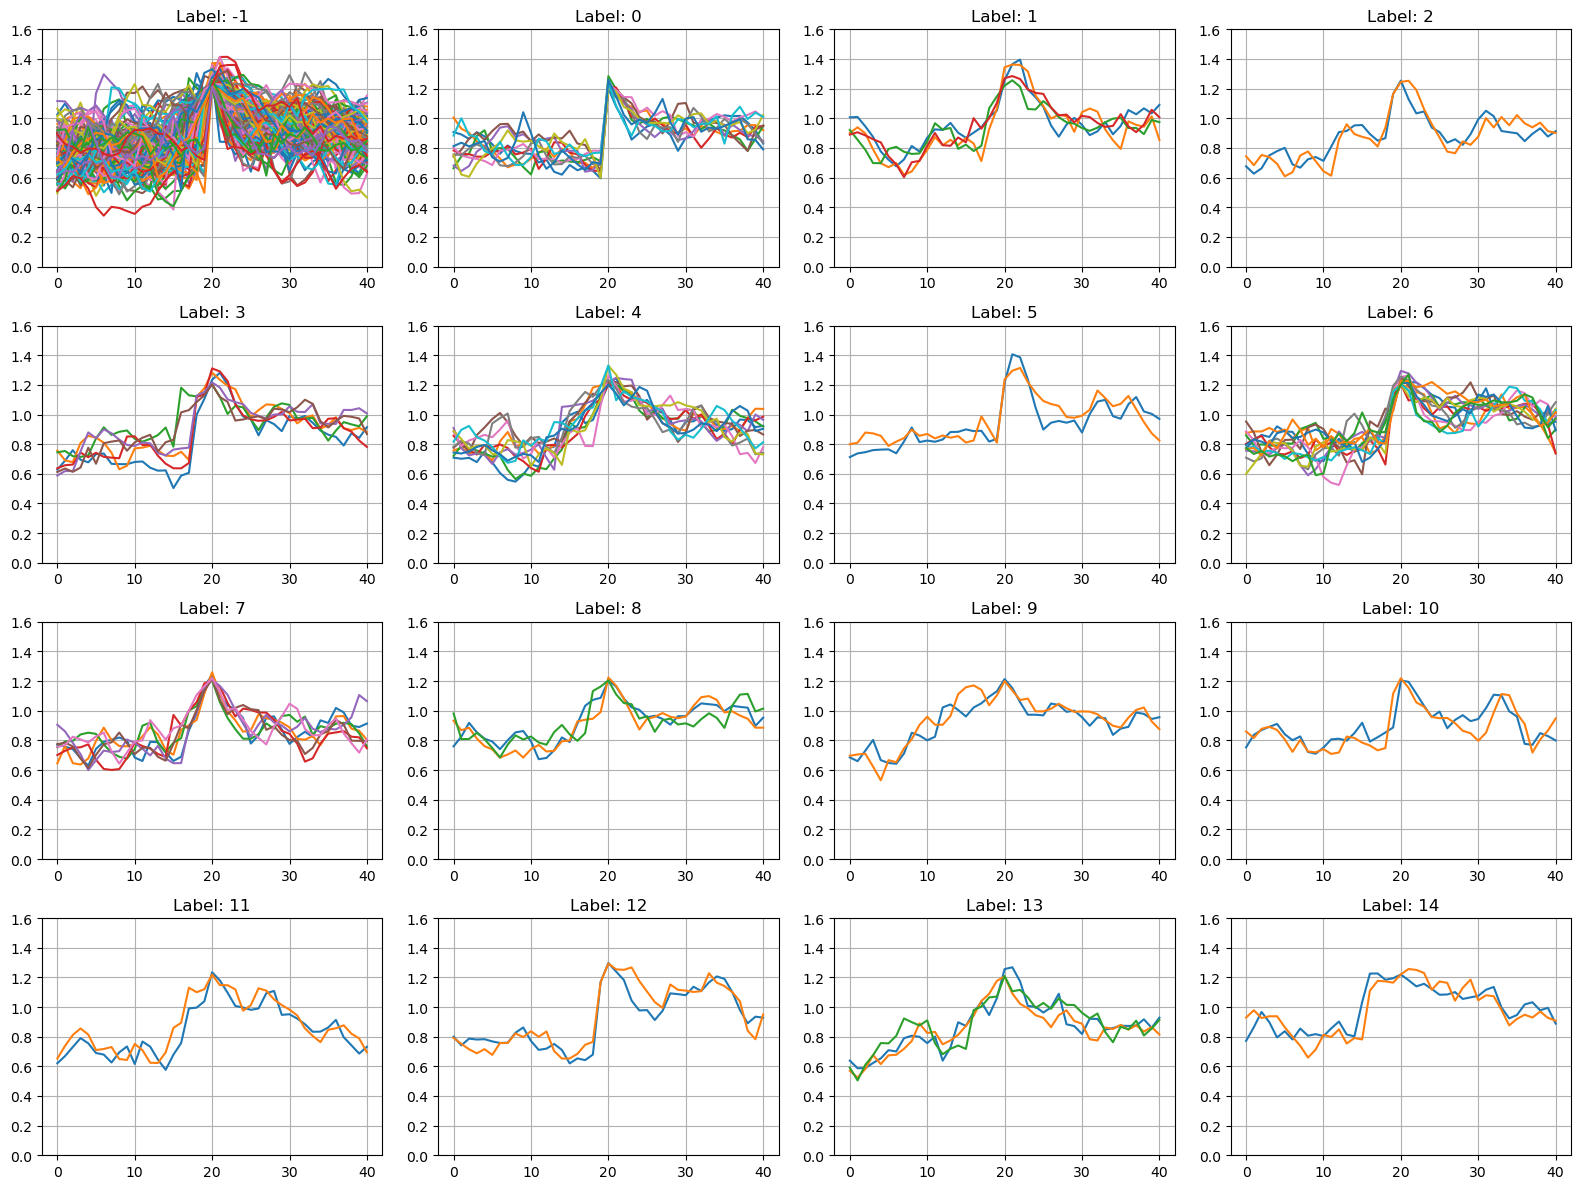

In [ ]:
import numpy as np

# assign DBSCAN labels to all rows in order
df_job.index = labels

# create datapoint groups by label
group_by_label = []

for label in np.unique(labels):
    df_temp = df_job.loc[[label]].T
    group_by_label.append(df_temp)

# create a grid of subplots, a cell for each label
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
ax_row = 0
ax_col = 0
label_index = 0

# visualize cluster
for group in group_by_label:
    group.plot(ax=axes[ax_row % 4, ax_col % 4], title="Label: "+str(np.unique(labels)[label_index]), grid=True, legend=False)

    # all plots should have the same y-axis scale
    axes[ax_row % 4, ax_col % 4].set_ylim(0.0, 1.6)

    # counters for filling the 4x4 grid (from left to right, up to down)
    ax_col += 1
    label_index += 1

    # create a new row if 4 plots are plotted
    if (ax_col % 4 == 0):
        ax_row += 1

plt.tight_layout()
plt.show()